In [1]:
import gzip
import json

data = []
with gzip.open("../dataset0.json.gz", "rt") as f:
    for line in f:
        data.append(json.loads(line))

In [2]:

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, confusion_matrix)
import matplotlib.pyplot as plt

In [4]:
def get_id_and_position(data):
    id = list(data.keys())[0]
    position = list(data[id].keys())[0]
    return id, position

def get_features(data):
    id, position = get_id_and_position(data)
    return list(data[id][position].values())[0]

In [5]:
feature_length = []
for i in data:
    feature_length.append(len(get_features(i)))

print(np.mean(feature_length))
print(f"minimum number of reads is {np.min(feature_length)}")
print(f"maximum number of reads is {np.max(feature_length)}")

90.506295244505
minimum number of reads is 20
maximum number of reads is 991


In [12]:
import pandas as pd

# Read the labelled info file
df_labels = pd.read_csv("../data.info.labelled")

label_dict = {
    (row.transcript_id, row.transcript_position): row.label
    for row in df_labels.itertuples(index=False)
}

In [16]:
X_data = []
y_data = []

for entry in data:
    id, position = get_id_and_position(entry)
    features = get_features(entry)
    label = label_dict.get((id, int(position)), None)
    X_data.append(features)
    y_data.append(label)
    
X_data = np.array(X_data)
y_data = np.array(y_data)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (121838,) + inhomogeneous part.

In [26]:
# for apple silicon (M1 chips and newer)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: mps


In [18]:
class M6ADataset(Dataset):
    def __init__(self, X, y, max_length=200):
        """
        Args:
            X: List of arrays, each with shape (9, N) where N is variable
            y: List of labels (0 or 1)
            max_length: Maximum sequence length (pads shorter sequences)
        """
        self.X = X
        self.y = y
        self.max_length = max_length
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x = self.X[idx]  # Shape: (N, 9) - N reads, 9 features
        y = self.y[idx]
        
        # Convert to numpy array if it's a list
        x = np.array(x)
        
        # Pad or truncate to max_length
        n_reads = x.shape[0]
        if n_reads < self.max_length:
            # Pad with zeros
            padding = np.zeros((self.max_length - n_reads, 9))
            x = np.vstack([x, padding])
        else:
            # Truncate to max_length
            x = x[:self.max_length]
        
        # Store original length for masking (optional, for attention)
        length = min(n_reads, self.max_length)
        
        return {
            'X': torch.FloatTensor(x),
            'y': torch.LongTensor([y]),
            'length': length
        }

In [19]:
class LSTMWithAttention(nn.Module):
    def __init__(self, input_size=9, hidden_size=64, num_layers=2, 
                dropout=0.3, output_size=2):
        super(LSTMWithAttention, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Attention layer
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=4,
            dropout=dropout,
            batch_first=True
        )
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, output_size)
        )
    
    def forward(self, x, lengths=None):
        """
        Args:
            x: Tensor of shape (batch_size, seq_len, input_size)
            lengths: Tensor of actual sequence lengths for masking
        Returns:
            logits: Tensor of shape (batch_size, output_size)
        """
        # LSTM forward pass
        lstm_out, (h_n, c_n) = self.lstm(x)
        
        # Apply attention
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        
        # Use last output
        last_out = attn_out[:, -1, :]
        
        # Classification
        logits = self.fc(last_out)
        
        return logits

In [20]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        X = batch['X'].to(device)
        y = batch['y'].squeeze().to(device)
        
        optimizer.zero_grad()
        logits = model(X, batch['length'])
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)


def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch in data_loader:
            X = batch['X'].to(device)
            y = batch['y'].squeeze().to(device)
            
            logits = model(X, batch['length'])
            loss = criterion(logits, y)
            total_loss += loss.item()
            
            # Get predictions
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    metrics = {
        'loss': total_loss / len(data_loader),
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds, zero_division=0),
        'recall': recall_score(all_labels, all_preds, zero_division=0),
        'f1': f1_score(all_labels, all_preds, zero_division=0),
        'auc': roc_auc_score(all_labels, all_probs) if len(np.unique(all_labels)) > 1 else 0
    }
    
    return metrics, all_preds, all_labels

In [27]:
def train_m6a_model(X_data, y_data, epochs=50, batch_size=16, 
                    max_length=200, learning_rate=0.001):
    """
    Train the m6A detection model.
    
    Args:
        X_data: List of numpy arrays with shape (9, N)
        y_data: List of binary labels
        epochs: Number of training epochs
        batch_size: Batch size for training
        max_length: Maximum sequence length
        learning_rate: Learning rate for optimizer
    
    Returns:
        model: Trained model
        history: Training history
    """
    
    # Normalize features
    print("Normalizing features...")
    scaler = StandardScaler()
    X_normalized = []
    for x in X_data:
        # Convert to numpy array if it's a list
        x = np.array(x)  # Shape: (N, 9)
        x_norm = scaler.fit_transform(x)  # Normalize each row independently
        X_normalized.append(x_norm)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_normalized, y_data, test_size=0.2, random_state=42, stratify=y_data
    )
    
    # Create datasets and dataloaders
    train_dataset = M6ADataset(X_train, y_train, max_length=max_length)
    test_dataset = M6ADataset(X_test, y_test, max_length=max_length)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model
    model = LSTMWithAttention(input_size=9, hidden_size=64, num_layers=2, 
                            dropout=0.3, output_size=2).to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=5
    )
    
    # Training loop
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_f1': [],
        'val_auc': []
    }
    
    best_f1 = 0
    patience = 10
    patience_counter = 0
    
    print(f"\nTraining on {device}...")
    print(f"Train set: {len(X_train)}, Test set: {len(X_test)}\n")
    
    for epoch in range(epochs):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        val_metrics, _, _ = evaluate(model, test_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_metrics['loss'])
        history['val_accuracy'].append(val_metrics['accuracy'])
        history['val_f1'].append(val_metrics['f1'])
        history['val_auc'].append(val_metrics['auc'])
        
        scheduler.step(val_metrics['f1'])
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val Loss: {val_metrics['loss']:.4f} | Acc: {val_metrics['accuracy']:.4f} | "
            f"F1: {val_metrics['f1']:.4f} | AUC: {val_metrics['auc']:.4f}")
        
        # Early stopping
        if val_metrics['f1'] > best_f1:
            best_f1 = val_metrics['f1']
            patience_counter = 0
            torch.save(model.state_dict(), 'best_m6a_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break
    
    # Load best model
    model.load_state_dict(torch.load('best_m6a_model.pth'))
    
    print("\nTraining complete!")
    return model, history, test_loader, criterion

In [22]:
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Loss
    axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
    axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Metrics
    axes[1].plot(history['val_accuracy'], label='Accuracy', marker='o')
    axes[1].plot(history['val_f1'], label='F1 Score', marker='s')
    axes[1].plot(history['val_auc'], label='AUC', marker='^')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Score')
    axes[1].set_title('Validation Metrics')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=100)
    plt.show()

Normalizing features...

Training on mps...
Train set: 97470, Test set: 24368

Epoch 1/50
  Train Loss: 0.1686
  Val Loss: 0.1501 | Acc: 0.9552 | F1: 0.0073 | AUC: 0.8201
Epoch 2/50
  Train Loss: 0.1514
  Val Loss: 0.1424 | Acc: 0.9563 | F1: 0.1461 | AUC: 0.8389
Epoch 3/50
  Train Loss: 0.1431
  Val Loss: 0.1437 | Acc: 0.9557 | F1: 0.0527 | AUC: 0.8435
Epoch 4/50
  Train Loss: 0.1395
  Val Loss: 0.1500 | Acc: 0.9566 | F1: 0.1950 | AUC: 0.8575
Epoch 5/50
  Train Loss: 0.1352
  Val Loss: 0.1391 | Acc: 0.9570 | F1: 0.3078 | AUC: 0.8666
Epoch 6/50
  Train Loss: 0.1307
  Val Loss: 0.1394 | Acc: 0.9572 | F1: 0.1885 | AUC: 0.8668
Epoch 7/50
  Train Loss: 0.1262
  Val Loss: 0.1375 | Acc: 0.9571 | F1: 0.1905 | AUC: 0.8528
Epoch 8/50
  Train Loss: 0.1218
  Val Loss: 0.1375 | Acc: 0.9564 | F1: 0.2844 | AUC: 0.8572
Epoch 9/50
  Train Loss: 0.1173
  Val Loss: 0.1538 | Acc: 0.9569 | F1: 0.2402 | AUC: 0.8431
Epoch 10/50
  Train Loss: 0.1116
  Val Loss: 0.1538 | Acc: 0.9566 | F1: 0.2165 | AUC: 0.8341


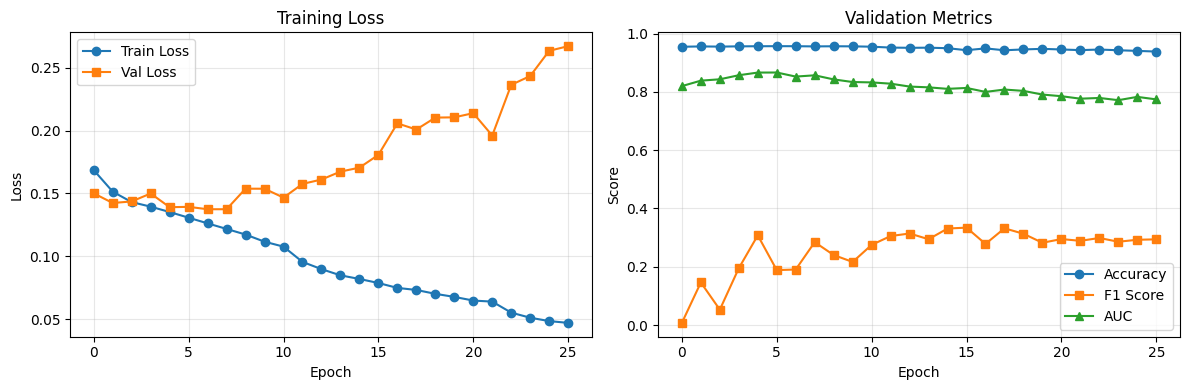


Final Test Metrics:
  loss: 0.1807
  accuracy: 0.9435
  precision: 0.3549
  recall: 0.3160
  f1: 0.3343
  auc: 0.8138

Confusion Matrix:
[[22644   629]
 [  749   346]]


In [28]:
np.random.seed(42)
n_samples = 100

model, history, test_loader, criterion = train_m6a_model(
        X_data, y_data, epochs=50, batch_size=16, max_length=200, learning_rate=0.001
    )

plot_training_history(history)
    
    # Final evaluation
final_metrics, preds, labels = evaluate(model, test_loader, criterion, device)
print("\nFinal Test Metrics:")
for key, val in final_metrics.items():
    print(f"  {key}: {val:.4f}")
    
cm = confusion_matrix(labels, preds)
print(f"\nConfusion Matrix:\n{cm}")

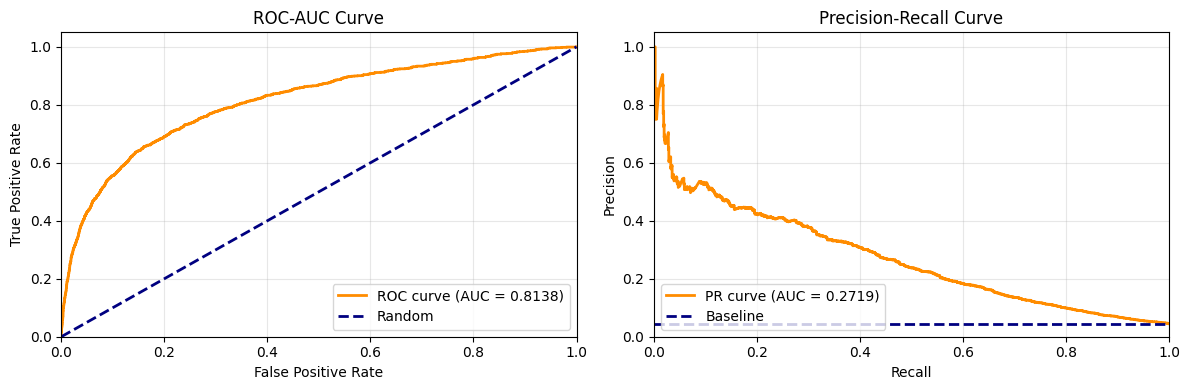


ROC-AUC Score: 0.8138
PR-AUC Score: 0.2719


In [29]:
def plot_roc_pr_curves(model, data_loader, device):
    """
    Plot ROC-AUC and PR-AUC curves for the model.
    
    Args:
        model: Trained model
        data_loader: DataLoader for evaluation
        device: Device to run on
    """
    from sklearn.metrics import roc_curve, auc, precision_recall_curve
    
    model.eval()
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch in data_loader:
            X = batch['X'].to(device)
            y = batch['y'].squeeze().to(device)
            
            logits = model(X, batch['length'])
            probs = torch.softmax(logits, dim=1)
            
            all_labels.extend(y.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    
    # Calculate PR curve
    precision, recall, _ = precision_recall_curve(all_labels, all_probs)
    pr_auc = auc(recall, precision)
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # ROC curve
    axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC-AUC Curve')
    axes[0].legend(loc="lower right")
    axes[0].grid(True, alpha=0.3)
    
    # PR curve
    axes[1].plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
    axes[1].axhline(y=np.mean(all_labels), color='navy', linestyle='--', lw=2, label='Baseline')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title('Precision-Recall Curve')
    axes[1].legend(loc="lower left")
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('roc_pr_curves.png', dpi=100)
    plt.show()
    
    print(f"\nROC-AUC Score: {roc_auc:.4f}")
    print(f"PR-AUC Score: {pr_auc:.4f}")
    
plot_roc_pr_curves(model, test_loader, device)
